This notebook contains the EDA and general preprocessing steps for three datasets:
- application_train/test
- bureau
- bureau_balance

Main steps
1) EDA
2) Category encoding
3) anomalies analysis
5) NaN analysis
6) feature engineering
6) exclusion of highly correlated features

Output:
- agregated train dataset ready for preprocessing pipeline and modelling

Source of data

https://www.kaggle.com/c/home-credit-default-risk/data

The following notebook is an adaptation of the two following notebooks available on kaggle by Will Koehrsen:
- https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
- https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering

## Loading datasets from kaggle

In [1]:
# name of dataset in kaggle API
data_name = 'home-credit-default-risk'
# Import OS for navigation and environment set up
import os
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = 'C:/Users/VP/Google Drive/Colab/Kaggle'
import kaggle
# Navigate into Drive where you want to store your Kaggle data
path_datasets = 'D:/Dowloads_D/Data_OC/P7'                                                                           # /!\ variable # folder for dowloaded datasets
os.chdir(path_datasets)
# check if the dataset has been already downloaded
if not os.path.exists('{}.zip'.format(data_name)):
    # Paste and run the copied API command, the data will download to the current directory
    # replace dataset name/competition after -d                                                                          # /!\ variable # dataset to download from kaggle
    !kaggle competitions download -d home-credit-default-risk
# now we extract the files form the zip file
from zipfile import ZipFile
with ZipFile('{}.zip'.format(data_name), 'r') as zip:
  zip.extractall()
  print('Done')

Done


## importing libraries and custom functions

In [2]:
seed = 42 # random state set for reproducibility

import numpy as np
import pandas as pd
import os
import re
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
plt.rc('figure', figsize=(10, 6))

import pickle
import IPython.display

In [3]:
"""display options"""
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# pd.reset_option("max_colwidth")

In [4]:
"""Importing personal functions and style params"""
os.chdir('C:/Users/VP/Google Drive/Education/OC/working_directory/personal_modules')
%run -i useful_functions.py

# Shape analysis

In [5]:
os.chdir('D:/Dowloads_D/Data_OC/P7' )
app_test = pd.read_csv('application_test.csv')
app_train = pd.read_csv('application_train.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
bureau = pd.read_csv('bureau.csv')
# credit = pd.read_csv('credit_card_balance.csv')
installments  = pd.read_csv('installments_payments.csv')
cash  = pd.read_csv('POS_CASH_balance.csv')
previous = pd.read_csv('previous_application.csv')
# df_raw_sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
app_train.shape

(307511, 122)

In [7]:
# let's gather our dfs in a dict in order to use the custom function below
dfs_dict = dict()

dfs_dict['app_test'] = app_test
dfs_dict['app_train'] = app_train
dfs_dict['bureau_balance'] = bureau_balance
dfs_dict['bureau'] = bureau
# dfs_dict['df_raw_credit_card'] = df_raw_credit_card
dfs_dict['installments'] = installments
dfs_dict['cash'] = cash
dfs_dict['previous'] = previous
# dfs_dict['df_raw_sample_submission'] = df_raw_sample_submission

In [8]:
# custom function that gives high level information on the datasets contained in the input dict
dfs_insight(dfs_dict)

  df-wise information 
          name_df             shape   % NaN # duplicated rows
0        app_test   ((48744, 121),)  23.81%                 0
1       app_train  ((307511, 122),)  24.40%                 0
2  bureau_balance  ((27299925, 3),)   0.00%                 0
3          bureau  ((1716428, 17),)  13.50%                 0
4    installments  ((13605401, 8),)   0.01%                 0
5            cash  ((10001358, 8),)   0.07%                 0
6        previous  ((1670214, 37),)  17.98%                 0 

  column-wise information 
 app_test 
                                dtype  # dupplicated entries avg_nan_col
SK_ID_CURR                      int64                    0.0       0.00%
NAME_CONTRACT_TYPE             object                48742.0       0.00%
CODE_GENDER                    object                48742.0       0.00%
FLAG_OWN_CAR                   object                48742.0       0.00%
FLAG_OWN_REALTY                object                48742.0       0.00%
CNT

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   

   ORGANIZATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
0       Kindergarten      0.752614      0.789654      0.159520   
1      Self-employed      0.564990      0.291656      0.432962   
2  Transport: type 3           NaN      0.699787      0.610991   

   APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0           0.066             0.059                       0.9732   
1             NaN               NaN                          NaN   
2             NaN               NaN                          NaN   

   YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
0              NaN             NaN            NaN         0.1379   
1              NaN             NaN            NaN            NaN   
2              NaN             NaN            NaN            NaN   

   FLOORSMAX_

----------------------------------------------------------------------
 app_train 
                                dtype  # dupplicated entries avg_nan_col
SK_ID_CURR                      int64                    0.0       0.00%
TARGET                          int64               307509.0       0.00%
NAME_CONTRACT_TYPE             object               307509.0       0.00%
CODE_GENDER                    object               307508.0       0.00%
FLAG_OWN_CAR                   object               307509.0       0.00%
FLAG_OWN_REALTY                object               307509.0       0.00%
CNT_CHILDREN                    int64               307496.0       0.00%
AMT_INCOME_TOTAL              float64               304963.0       0.00%
AMT_CREDIT                    float64               301908.0       0.00%
AMT_ANNUITY                   float64               293838.0       0.00%
AMT_GOODS_PRICE               float64               306508.0       0.09%
NAME_TYPE_SUITE                object    

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  \
0                       0                        0  Business Entity Type 3   
1                       0                        0                  School   
2                       0                        0              Government   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   
2           NaN      0.555912      0.729567             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   
1                       0.9851           0.7960          0.0605   
2                          NaN              NaN             NaN   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0     

----------------------------------------------------------------------
 bureau_balance 
                 dtype  # dupplicated entries avg_nan_col
SK_ID_BUREAU     int64               26482530       0.00%
MONTHS_BALANCE   int64               27299828       0.00%
STATUS          object               27299917       0.00%

first 3 rows



SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C

----------------------------------------------------------------------
 bureau 
                          dtype  # dupplicated entries avg_nan_col
SK_ID_CURR                int64              1410617.0       0.00%
SK_ID_BUREAU              int64                    0.0       0.00%
CREDIT_ACTIVE            object              1716424.0       0.00%
CREDIT_CURRENCY          object              1716424.0       0.00%
DAYS_CREDIT               int64              1713505.0       0.00%
CREDIT_DAY_OVERDUE        int64              1715486.0       0.00%
DAYS_CREDIT_ENDDATE     float64              1702331.0       6.15%
DAYS_ENDDATE_FACT       float64              1713510.0      36.92%
AMT_CREDIT_MAX_OVERDUE  float64              1648176.0      65.51%
CNT_CREDIT_PROLONG        int64              1716418.0       0.00%
AMT_CREDIT_SUM          float64              1479719.0       0.00%
AMT_CREDIT_SUM_DEBT     float64              1489890.0      15.01%
AMT_CREDIT_SUM_LIMIT    float64              1664

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN

----------------------------------------------------------------------
 installments 
                          dtype  # dupplicated entries avg_nan_col
SK_ID_PREV                int64               12607649       0.00%
SK_ID_CURR                int64               13265814       0.00%
NUM_INSTALMENT_VERSION  float64               13605336       0.00%
NUM_INSTALMENT_NUMBER     int64               13605124       0.00%
DAYS_INSTALMENT         float64               13602479       0.00%
DAYS_ENTRY_PAYMENT      float64               13602361       0.02%
AMT_INSTALMENT          float64               12702862       0.00%
AMT_PAYMENT             float64               12661165       0.02%

first 3 rows



SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000

----------------------------------------------------------------------
 cash 
                         dtype  # dupplicated entries avg_nan_col
SK_ID_PREV               int64                9065033       0.00%
SK_ID_CURR               int64                9664106       0.00%
MONTHS_BALANCE           int64               10001262       0.00%
CNT_INSTALMENT         float64               10001284       0.26%
CNT_INSTALMENT_FUTURE  float64               10001278       0.26%
NAME_CONTRACT_STATUS    object               10001349       0.00%
SK_DPD                   int64                9997958       0.00%
SK_DPD_DEF               int64                9999051       0.00%

first 3 rows



SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0

----------------------------------------------------------------------
 previous 
                               dtype  # dupplicated entries avg_nan_col
SK_ID_PREV                     int64                    0.0       0.00%
SK_ID_CURR                     int64              1331357.0       0.00%
NAME_CONTRACT_TYPE            object              1670210.0       0.00%
AMT_ANNUITY                  float64              1312254.0      22.29%
AMT_APPLICATION              float64              1576329.0       0.00%
AMT_CREDIT                   float64              1583410.0       0.00%
AMT_DOWN_PAYMENT             float64              1640935.0      53.64%
AMT_GOODS_PRICE              float64              1576328.0      23.08%
WEEKDAY_APPR_PROCESS_START    object              1670207.0       0.00%
HOUR_APPR_PROCESS_START        int64              1670190.0       0.00%
FLAG_LAST_APPL_PER_CONTRACT   object              1670212.0       0.00%
NFLAG_LAST_APPL_IN_DAY         int64              1670

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   

   DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
0           -42.0                      300.0          -42.0             -37.0   
1          -134.0                      916.0       365243.0          365243.0   
2          -271.0                       59.0       365243.0          365243.0   

   NFLAG_INSURED_ON_APPROVAL  
0                        0.0  
1                        1.0  
2                        1.0

----------------------------------------------------------------------


In [9]:
# before exploring tables let's check how many loan IDs from the main table 'application_train' we can find in other tables
# if it's low then the table can be discarded
for name, df in dfs_dict.items():
  if name not in ['app_test', 'bureau_balance']:
    print(name, '# IDs :', len(df['SK_ID_CURR'].unique()))
    perc_IDs = len(df[df.SK_ID_CURR.isin(app_train.SK_ID_CURR.unique())].SK_ID_CURR.unique())/307511
    print('    % IDs from application :', '{:.1%}'.format(perc_IDs))

app_train # IDs : 307511
    % IDs from application : 100.0%
bureau # IDs : 305811
    % IDs from application : 85.7%
installments # IDs : 339587
    % IDs from application : 94.8%
cash # IDs : 337252
    % IDs from application : 94.1%
previous # IDs : 338857
    % IDs from application : 94.6%


With information about only 30% of loans the credit card table will not be useful for modelling, excluding it from the dfs_dict

# Columns drop with respect to GDPR

In [10]:
# gender cannot be a bias into granting a loan
app_train.drop(columns='CODE_GENDER', inplace=True)
app_test.drop(columns='CODE_GENDER', inplace=True)

# Example exploration

Let's explore the database following a SK_ID_CURR

In [11]:
"""
This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.
"""
# let's take an id of a loan SK_ID_CURR and see what it matches in the different tables (id chosen to avoid NaN)
ex_id = 337855
app_train[app_train.SK_ID_CURR == ex_id]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE FLAG_OWN_CAR FLAG_OWN_REALTY  \
205190      337855       0         Cash loans            N               Y   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
205190             2          135000.0    297130.5      21618.0   

        AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE NAME_EDUCATION_TYPE  \
205190         256500.0          Family    State servant   Incomplete higher   

       NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
205190            Married  House / apartment                    0.019101   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
205190      -10600          -1566            -2565.0            -3279   

        OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
205190          NaN           1               1                0   

        FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
205190                 1           0           0        Laborers   

        CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
205190              4.0                     2                            2   

       WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
205190                     MONDAY                       15   

        REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
205190                           0                           0   

        LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
205190                            0                       0   

        REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY ORGANIZATION_TYPE  \
205190                       1                        1        Government   

        EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  \
205190      0.212667      0.042491      0.353988             NaN   

        BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  \
205190               NaN                          NaN              NaN   

        COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  \
205190             NaN            NaN            NaN            NaN   

        FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
205190            NaN           NaN                   NaN             NaN   

        NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
205190                      NaN                NaN              NaN   

        BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
205190                NaN                           NaN               NaN   

        COMMONAREA_MODE  ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  \
205190              NaN             NaN             NaN             NaN   

        FLOORSMIN_MODE  LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  \
205190             NaN            NaN                    NaN              NaN   

        NONLIVINGAPARTMENTS_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  \
205190                       NaN                 NaN              NaN   

        BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
205190                NaN                           NaN               NaN   

        COMMONAREA_MEDI  ELEVATORS_MEDI  ENTRANCES_MEDI  FLOORSMAX_MEDI  \
205190              NaN             NaN             NaN             NaN   

        FLOORSMIN_MEDI  LANDAREA_MEDI  LIVINGAPARTMENTS_MEDI  LIVINGAREA_MEDI  \
205190             NaN            NaN                    NaN              NaN   

        NONLIVINGAPARTMENTS_MEDI  NONLIVINGAREA_MEDI FONDKAPREMONT_MODE  \
205190                       NaN                 NaN                NaN   

       HOUSETYPE_MODE  TOTALAREA_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  \
205190            NaN             NaN                NaN                 NaN   

        OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
205190                       0.0                       0.0   

        OBS_60_CNT_SOCIAL_CIRCLE  D

In [12]:
"""
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.
"""
bureau[bureau.SK_ID_CURR == ex_id].sort_values(by='SK_ID_BUREAU')

# 1 row = past or ongoing credit not contracted with home credit ?
# column AMT_CREDIT_MAX_OVERDUE sums up burean balance in fact ?

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
462128      337855       5976342        Closed      currency 1        -1291   
462129      337855       5976343        Closed      currency 1        -2120   
462130      337855       5976344        Closed      currency 1         -342   
334088      337855       6409660        Closed      currency 1        -1762   
334089      337855       6409662        Active      currency 1         -342   
334090      337855       6409663        Active      currency 1         -646   
334091      337855       6409664        Active      currency 1         -988   
334092      337855       6409665        Active      currency 1         -340   
334093      337855       6409666        Closed      currency 1        -1761   
334094      337855       6409667        Active      currency 1          -97   
334095      337855       6409668        Active      currency 1         -618   
334096      337855       6409669        Active      currency 1         -189   

        CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
462128                   0                536.0             -340.0   
462129                   0              -1756.0            -1127.0   
462130                   0                  NaN             -209.0   
334088                   0              -1547.0            -1536.0   
334089                   0              30971.0                NaN   
334090                   0                442.0                NaN   
334091                   0                411.0                NaN   
334092                   0               1486.0                NaN   
334093                   0              -1547.0            -1547.0   
334094                   0                127.0                NaN   
334095                   0                  NaN                NaN   
334096                   0                114.0                NaN   

        AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
462128                     NaN                   0        414000.0   
462129                     NaN                   0         47790.0   
462130                     0.0                   0             0.0   
334088                     NaN                   0         67509.0   
334089                     NaN                   0         45000.0   
334090                     NaN                   0         54000.0   
334091                     NaN                   0        225000.0   
334092                     NaN                   0        400500.0   
334093                     NaN                   0         67509.0   
334094                     NaN                   0         67500.0   
334095                     NaN                   0        247500.0   
334096                     NaN                   0         39060.0   

        AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
462128                  0.0                   0.0                     0.0   
462129                  NaN                   NaN                     0.0   
462130                  0.0                   0.0                     0.0   
334088                  0.0                   0.0                     0.0   
334089              16501.5                   0.0                     0.0   
334090              55800.0                   0.0                     0.0   
334091             228582.0                   0.0                     0.0   
334092             359388.0                   0.0                     0.0   
334093                  0.0                   NaN                     0.0   
334094             129600.0                   NaN                     0.0   
334095                  NaN                   NaN                     0.0   
334096              16618.5                   NaN                     0.0   

            CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
462128  Consumer credit                -217          NaN  
462129  Consumer credit               

In [13]:
"""
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has 
(#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.
STATUS: [C means closed, X means status unknown, 0 means no DPD, 1 means maximal DPD during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off
"""
# let's now filter on a SK_ID_BUREAU associated with loan ex_id thanks to df_raw_bureau above
bureau_balance[bureau_balance.SK_ID_BUREAU == 6409660]

SK_ID_BUREAU  MONTHS_BALANCE STATUS
7038293       6409660               0      C
7038294       6409660              -1      C
7038295       6409660              -2      C
7038296       6409660              -3      C
7038297       6409660              -4      C
7038298       6409660              -5      C
7038299       6409660              -6      C
7038300       6409660              -7      C
7038301       6409660              -8      C
7038302       6409660              -9      C
7038303       6409660             -10      C
7038304       6409660             -11      C
7038305       6409660             -12      C
7038306       6409660             -13      C
7038307       6409660             -14      C
7038308       6409660             -15      C
7038309       6409660             -16      C
7038310       6409660             -17      C
7038311       6409660             -18      C
7038312       6409660             -19      C
7038313       6409660             -20      C
7038314       6409660             -21      C
7038315       6409660             -22      C
7038316       6409660             -23      C
7038317       6409660             -24      C
7038318       6409660             -25      0
7038319       6409660             -26      0
7038320       6409660             -27      0
7038321       6409660             -28      0
7038322       6409660             -29      0
7038323       6409660             -30      0
7038324       6409660             -31      0
7038325       6409660             -32      0
7038326       6409660             -33      0
7038327       6409660             -34      0
7038328       6409660             -35      0
7038329       6409660             -36      0
7038330       6409660             -37      0
7038331       6409660             -38      0
7038332       6409660             -39      0
7038333       6409660             -40      0
7038334       6409660             -41      0
7038335       6409660             -42      0
7038336       6409660             -43      0
7038337       6409660             -44      0
7038338       6409660             -45      0
7038339       6409660             -46      0
7038340       6409660             -47      0
7038341       6409660             -48      0
7038342       6409660             -49      0
7038343       6409660             -50      0
7038344       6409660             -51      0
7038345       6409660             -52      0
7038346       6409660             -53      0
7038347       6409660             -54      0
7038348       6409660             -55      0
7038349       6409660             -56      0
7038350       6409660             -57      X

In [14]:
"""
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample
 – i.e. the table has 
 (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
"""
cash[cash.SK_ID_CURR == ex_id].sort_values(by='MONTHS_BALANCE')

# previous credits with home credits, different form the ones we have in df_raw_bureau ?

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
9288498     2004877      337855             -96            11.0   
4726340     2004877      337855             -95            11.0   
1863506     2004877      337855             -94            11.0   
6627736     2313467      337855             -94            20.0   
5943865     2004877      337855             -93            11.0   
9866652     2313467      337855             -93            20.0   
7832111     2313467      337855             -92            20.0   
8239416     2004877      337855             -92            11.0   
7760822     2313467      337855             -91            20.0   
7216148     2313467      337855             -90            20.0   
9734597     2313467      337855             -89            20.0   
9668678     2313467      337855             -88            20.0   
9940442     2313467      337855             -87            20.0   
9365405     2313467      337855             -86            20.0   
7831017     2313467      337855             -85            20.0   
9587297     2313467      337855             -84            20.0   
5853944     1035917      337855             -84             9.0   
4847449     1035917      337855             -83             9.0   
9666520     2313467      337855             -83            20.0   
8967065     1416845      337855             -82             8.0   
2033427     1035917      337855             -82             9.0   
9586416     2313467      337855             -82            20.0   
7593529     2313467      337855             -81            20.0   
2818939     1035917      337855             -81             9.0   
8612379     1416845      337855             -81             8.0   
1341880     1035917      337855             -80             9.0   
6589314     1416845      337855             -80             8.0   
8874980     2313467      337855             -80            20.0   
6518514     2313467      337855             -79            20.0   
76758       1035917      337855             -79             9.0   
9552339     1416845      337855             -79             8.0   
8845531     1035917      337855             -78             9.0   
4949675     2313467      337855             -78            20.0   
1506663     1416845      337855             -78             8.0   
8532928     1035917      337855             -77             9.0   
9384332     1416845      337855             -77             8.0   
9947554     2313467      337855             -77            20.0   
9742957     2313467      337855             -76            20.0   
9253001     1416845      337855             -76             8.0   
7502136     1035917      337855             -76             9.0   
2242049     1035917      337855             -75             9.0   
6892080     1416845      337855             -75             8.0   
9474759     2313467      337855             -75            20.0   
9362985     1416845      337855             -74             8.0   
9546707     2313467      337855             -74            20.0   
9473191     1721911      337855             -54            24.0   
5300996     1721911      337855             -53            24.0   
3405630     1721911      337855             -52            24.0   
773705      2247260      337855             -52            24.0   
2585669     1721911      337855             -51            24.0   
7546058     2247260      337855             -51            24.0   
9284011     2247260      337855             -50            24.0   
2165914     1721911      337855             -50            24.0   
709975      1721911      337855             -49            24.0   
7664020     2247260      337855             -49            24.0   
436800      1721911      337855             -48            24.0   
9144718     2247260      337855             -48            24.0   
387710      1721911      337855             -47            24.0   
2828321     2247260      337855             -47         

In [15]:
"""
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample 
– i.e. the table has 
(#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.
"""
# let's consider SK_ID_PREV asscociated with ex_id thanks to df_raw_previous_application above
# credit[credit.SK_ID_CURR == ex_id]

'\nMonthly balance snapshots of previous credit cards that the applicant has with Home Credit.\nThis table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample \n– i.e. the table has \n(#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.\n'

In [16]:
"""
All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.
"""
previous[previous.SK_ID_CURR == ex_id].head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
76405      1389964      337855         Cash loans    17326.485   
247929     2313467      337855         Cash loans     7262.730   
328312     1497990      337855         Cash loans          NaN   
347949     1658550      337855    Revolving loans     7875.000   
358535     1347131      337855         Cash loans    20123.865   

        AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
76405          450000.0    524250.0               NaN         450000.0   
247929          90000.0     99900.0               0.0          90000.0   
328312              0.0         0.0               NaN              NaN   
347949         157500.0    157500.0               0.0         157500.0   
358535         225000.0    254700.0               NaN         225000.0   

       WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
76405                      MONDAY                       18   
247929                     FRIDAY                       12   
328312                     FRIDAY                       10   
347949                     FRIDAY                       13   
358535                     MONDAY                       17   

       FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  \
76405                            Y                       1                NaN   
247929                           Y                       1                0.0   
328312                           Y                       1                NaN   
347949                           Y                       1                0.0   
358535                           Y                       1                NaN   

        RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
76405                     NaN                       NaN   
247929                    NaN                       NaN   
328312                    NaN                       NaN   
347949                    NaN                       NaN   
358535                    NaN                       NaN   

       NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  DAYS_DECISION  \
76405                   Other             Approved           -867   
247929                    XNA             Approved          -2859   
328312                    XNA             Canceled           -444   
347949                    XAP              Refused           -556   
358535                Repairs              Refused           -567   

            NAME_PAYMENT_TYPE CODE_REJECT_REASON NAME_TYPE_SUITE  \
76405   Cash through the bank                XAP   Unaccompanied   
247929                    XNA                XAP             NaN   
328312                    XNA                XAP             NaN   
347949                    XNA              SCOFR             NaN   
358535  Cash through the bank              LIMIT             NaN   

       NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
76405          Repeater                 XNA           Cash           walk-in   
247929         Repeater                 XNA           Cash            x-sell   
328312         Repeater                 XNA            XNA               XNA   
347949         Repeater                 XNA          Cards           walk-in   
358535         Repeater                 XNA           Cash           walk-in   

                   CHANNEL_TYPE  SELLERPLACE_AREA  NAME_SELLER_INDUSTRY  \
76405   Credit and cash offices                -1                   XNA   
247929             Country-wide                -1  Consumer electronics   
328312  Credit and cash offices                -1                   XNA   
347949             Country-wide                27          Connectivity   
358535             Country-wide                52          Connectivity   

        CNT_PAYMENT NAME_YIELD_GROUP  PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
76405          48.0       low_normal     Cash Street: low            365243.0   
247929         20.0           mid

In [17]:
"""
Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.
"""
installments[installments.SK_ID_CURR == ex_id].sort_values(by='NUM_INSTALMENT_NUMBER')

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
8417741      1035917      337855                     1.0   
8799446      1389964      337855                     1.0   
11119720     2247260      337855                     1.0   
9581012      1721911      337855                     1.0   
10806376     2313467      337855                     1.0   
7821433      1389973      337855                     0.0   
7856722      2313467      337855                     1.0   
9707041      1160018      337855                     1.0   
10392580     2360969      337855                     1.0   
11472877     1430239      337855                     1.0   
9866338      1416845      337855                     1.0   
9961281      2800280      337855                     1.0   
8293072      2247260      337855                     1.0   
9608853      1035917      337855                     1.0   
9661635      1389973      337855                     0.0   
9803124      1430239      337855                     1.0   
11474618     2313467      337855                     1.0   
10044815     1721911      337855                     1.0   
10088142     2360969      337855                     1.0   
10416570     1416845      337855                     1.0   
10677025     1160018      337855                     1.0   
10679190     2800280      337855                     1.0   
9930633      1389964      337855                     1.0   
10389595     1416845      337855                     1.0   
9593006      1035917      337855                     1.0   
11016210     1389973      337855                     0.0   
9497163      2247260      337855                     1.0   
11057452     1389964      337855                     1.0   
9048809      1416845      337855                     1.0   
8831330      1721911      337855                     1.0   
11353745     1160018      337855                     1.0   
8576726      2800280      337855                     1.0   
8476854      2360969      337855                     1.0   
7628796      2313467      337855                     1.0   
8293863      1430239      337855                     1.0   
8258711      1389973      337855                     0.0   
10601112     1721911      337855                     1.0   
11165986     2800280      337855                     1.0   
9839363      2247260      337855                     1.0   
9756689      1035917      337855                     1.0   
10351357     1416845      337855                     1.0   
8917158      1160018      337855                     1.0   
9474619      1430239      337855                     1.0   
9038056      2313467      337855                     1.0   
8498681      1389964      337855                     1.0   
10934175     1389964      337855                     1.0   
8352517      1416845      337855                     1.0   
10164190     2313467      337855                     1.0   
11292097     2360969      337855                     1.0   
9690782      1416845      337855                     1.0   
10669932     2313467      337855                     1.0   
10606970     1389964      337855                     1.0   
11166980     1160018      337855                     1.0   
9251169      1035917      337855                     1.0   
9456298      1389964      337855                     1.0   
11300142     1416845      337855                     1.0   
9980392      1430239      337855                     1.0   
8693468      2247260      337855                     1.0   
7995445      1389973      337855                     0.0   
10103896     2800280      337855                     1.0   
9360824      2360969      337855                     1.0   
10288473     1721911      337855                     1.0   
7900542      2800280      337855                     1.0   
11036098     2360969      337855                     1.0   
7786846      1416845      337855                     1.0   
10427565     1035917      337855                  

# Application dataset

## Converting object variables to categories

In [18]:
# building a transformer to convert all 'object' features to pandas category type
from sklearn.base import BaseEstimator, TransformerMixin
class obj_to_cat(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for col in X.columns:
            if X[col].dtype == 'object':
                X[col] = X[col].astype('category')
                
        return X         

In [19]:
cat_convert = obj_to_cat()

In [20]:
app_train = cat_convert.transform(app_train)

In [21]:
app_train['FLAG_DOCUMENT_3'].value_counts()

1    218340
0     89171
Name: FLAG_DOCUMENT_3, dtype: int64

## groups of columns types

In [22]:
app_train.dtypes.value_counts()

float64     65
int64       41
category     2
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
dtype: int64

In [24]:
# grouping column names by type and subtype to ease the exploration
# list of numeric features
app_train_num             = [col for col in app_train.columns if app_train[col].dtype in ['int64', 'float64']]
# list of numeric features with cadinality < 20 (discrete variables that can be viewed as categories)
app_train_num_card_l_20   = [col for col in app_train.columns if app_train[col].dtype in ['int64', 'float64'] if len(app_train[col].unique()) < 20]
# list of numeric features with cadinality > 20 
app_train_num_card_m_20   = [col for col in app_train.columns if app_train[col].dtype in ['int64', 'float64'] if len(app_train[col].unique()) >= 20]
# list of categorical features
app_train_cats            = [col for col in app_train.columns if app_train[col].dtype not in ['int64', 'float64']]
# list of categorical features with card <= 2 (useful for encoding)
app_train_cats_card_le_2  = [col for col in app_train.columns if app_train[col].dtype not in ['int64', 'float64'] if len(app_train[col].unique()) <= 2]
# list of categorical features with card > 2 (useful for encoding)
app_train_cats_card_m_2   = [col for col in app_train.columns if app_train[col].dtype not in ['int64', 'float64'] if len(app_train[col].unique()) > 2]

## Categories cardinality

In [25]:
# cardinality of categorical variables
for name, df in dfs_dict.items():
    print('\n', name, '\n')
    print(df.select_dtypes('category').apply(pd.Series.nunique, axis = 0))


 app_test 

Series([], dtype: float64)

 app_train 

NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

 bureau_balance 

Series([], dtype: float64)

 bureau 

Series([], dtype: float64)

 installments 

Series([], dtype: float64)

 cash 

Series([], dtype: float64)

 previous 

Series([], dtype: float64)


## First NaN check

In [26]:
app_train.isna().sum().sort_values(ascending=False).head(100)
list(app_train.columns)
app_train[[ 'DAYS_BIRTH', 'DAYS_EMPLOYED',]].isna().sum().sort_values(ascending=False).head(100)

DAYS_BIRTH       0
DAYS_EMPLOYED    0
dtype: int64

## Category encoding

We label encode categories with cardinality <=2 and OneHot encode other categories

In [27]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

In [28]:
# prototype of encoder below
# not working because OneHotencoder returns an array without the names of the columns.
encoding_pipe = ColumnTransformer([
    ('card_le_2', OrdinalEncoder(), app_train_cats_card_le_2),
    ('card_m_2', OneHotEncoder(), app_train_cats_card_m_2),
], remainder='passthrough')  

In [29]:
# Create a label encoder object for cat vars with cardinality < 3
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if pd.api.types.is_categorical_dtype(app_train[col].dtype):
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [30]:
# one-hot encoding of categorical variables with cardinality >= 3
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 237)


In [31]:
app_train.dtypes.values

array([dtype('int64'), dtype('int64'), dtype('int32'), dtype('int32'),
       dtype('int32'), dtype('int64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('int64'), dtype('int64'), dtype('float64'), dtype('int64'),
       dtype('float64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('float64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'),
       dtype('int64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       

## Aligning Training and Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to align the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set axis = 1 to align the dataframes based on the columns and not on the rows!

In [32]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 238)
Testing Features shape:  (48744, 237)


## EDA app_train

### highly correlated features in app_train

In [33]:
app_train_corr = app_train.corr()
app_train_corr

SK_ID_CURR  \
SK_ID_CURR                                           1.000000   
NAME_CONTRACT_TYPE                                   0.001654   
FLAG_OWN_CAR                                         0.001216   
FLAG_OWN_REALTY                                      0.000703   
CNT_CHILDREN                                        -0.001129   
AMT_INCOME_TOTAL                                    -0.001820   
AMT_CREDIT                                          -0.000343   
AMT_ANNUITY                                         -0.000433   
AMT_GOODS_PRICE                                     -0.000232   
REGION_POPULATION_RELATIVE                           0.000849   
DAYS_BIRTH                                          -0.001500   
DAYS_EMPLOYED                                        0.001366   
DAYS_REGISTRATION                                   -0.000973   
DAYS_ID_PUBLISH                                     -0.000384   
OWN_CAR_AGE                                          0.001818   
FLAG_MOBIL                                           0.002804   
FLAG_EMP_PHONE                                      -0.001337   
FLAG_WORK_PHONE                                     -0.000415   
FLAG_CONT_MOBILE                                     0.002815   
FLAG_PHONE                                           0.002753   
FLAG_EMAIL                                           0.000281   
CNT_FAM_MEMBERS                                     -0.002895   
REGION_RATING_CLIENT                                -0.001075   
REGION_RATING_CLIENT_W_CITY                         -0.001138   
HOUR_APPR_PROCESS_START                              0.000350   
REG_REGION_NOT_LIVE_REGION                          -0.000283   
REG_REGION_NOT_WORK_REGION                           0.001097   
LIVE_REGION_NOT_WORK_REGION                          0.002903   
REG_CITY_NOT_LIVE_CITY                              -0.001885   
REG_CITY_NOT_WORK_CITY                              -0.001582   
LIVE_CITY_NOT_WORK_CITY                              0.000067   
EXT_SOURCE_1                                         0.000082   
EXT_SOURCE_2                                         0.002342   
EXT_SOURCE_3                                         0.000222   
APARTMENTS_AVG                                       0.001556   
BASEMENTAREA_AVG                                    -0.002070   
YEARS_BEGINEXPLUATATION_AVG                          0.001551   
YEARS_BUILD_AVG                                      0.005900   
COMMONAREA_AVG                                      -0.001463   
ELEVATORS_AVG                                        0.004862   
ENTRANCES_AVG                                       -0.002879   
FLOORSMAX_AVG                                        0.004851   
FLOORSMIN_AVG                                        0.003083   
LANDAREA_AVG                                         0.001465   
LIVINGAPARTMENTS_AVG                                 0.003119   
LIVINGAREA_AVG                                       0.001770   
NONLIVINGAPARTMENTS_AVG                             -0.002575   
NONLIVINGAREA_AVG                                    0.003042   
APARTMENTS_MODE                                      0.001961   
BASEMENTAREA_MODE                                   -0.001411   
YEARS_BEGINEXPLUATATION_MODE                         0.001890   
YEARS_BUILD_MODE                                     0.005245   
COMMONAREA_MODE                                     -0.001058   
ELEVATORS_MODE                                       0.005017   
ENTRANCES_MODE                                      -0.002844   
FLOORSMAX_MODE                                       0.004386   
FLOORSMIN_MODE                                       0.002081   
LANDAREA_MODE                                        0.001548   
LIVINGAPARTMENTS_MODE                                0.003589   
LIVINGAREA_MODE                                      0.002156   
NONLIVINGAPARTMENTS_MODE                            -0.001923   
NONLIVINGAREA_MODE   

In [34]:
high_corr_pairs = dict()
for i in range(app_train_corr.shape[0]):
    for j in range(app_train_corr.shape[1]):
        if i!=j:
            if app_train_corr.iloc[i,j] > 0.8:
                high_corr_pairs[tuple(sorted([app_train_corr.index[i], app_train_corr.columns[j]]))] = round(app_train_corr.iloc[i,j], 2)
        

In [35]:
len(high_corr_pairs)

115

There are 111 pairs of features correlated at more than 0.8, which mean we could exclude a significant number of features without loosing information

### Examine the Distribution of the Target Column

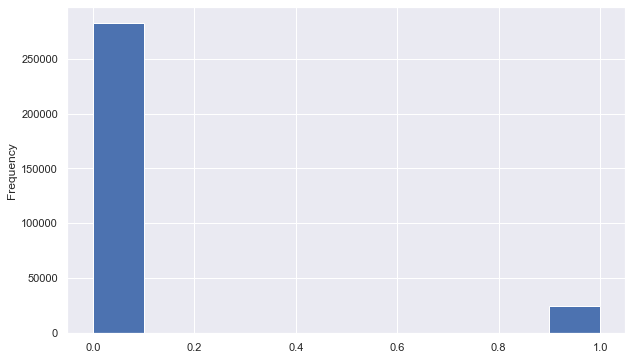

In [36]:
app_train['TARGET'].astype(int).plot.hist();

In [106]:
app_train['TARGET'].value_counts().values[1] / app_train['TARGET'].value_counts().values

array([0.08781829, 1.        ])

From this information, we see this is an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

### Anomalies

#### Day_births

In [37]:
# lets's see the age of clients
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Looks consistent

#### Day_Employed

In [38]:
# lets's see the years of employement
(app_train['DAYS_EMPLOYED'] / -365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

ok the minimum number of years of employement is -1000 which is abnormal

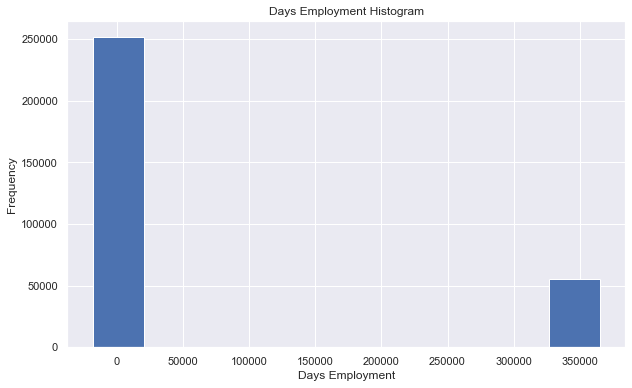

In [39]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [40]:
anom = app_train[app_train['DAYS_EMPLOYED'] > 365240]
non_anom = app_train[app_train['DAYS_EMPLOYED'] <= 365240]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default.

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (np.nan) and then create a new boolean column indicating whether or not the value was anomalous.

In [41]:
# let's check what is the second highest value for DAYS_EMPLOYED
sorted(app_train["DAYS_EMPLOYED"].unique(), reverse=True)[:3]

[365243, 0, -1]

In [42]:
(app_train["DAYS_EMPLOYED"] < 0).value_counts()

True     252135
False     55376
Name: DAYS_EMPLOYED, dtype: int64

In [43]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] > 0

In [44]:
# Replace the anomalous values with nan
app_train.loc[(app_train['DAYS_EMPLOYED'] > 0), 'DAYS_EMPLOYED'] = np.NaN

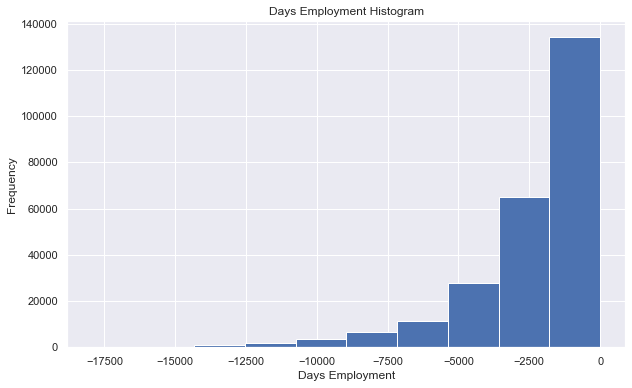

In [45]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (becuase we will have to fill in the nans with some value, probably the median of the column). The other columns with DAYS in the dataframe look to be about what we expect with no obvious outliers.

As an extremely important note, anything we do to the training data we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with np.nan in the testing data.

In [46]:
# Create an anomalous flag column
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] > 0
# Replace the anomalous values with nan
app_test.loc[(app_test['DAYS_EMPLOYED'] > 0), 'DAYS_EMPLOYED'] = np.NaN

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### Correlations

#### Target Vs features

In [47]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Let's take a look at some of more significant correlations: the DAYS_BIRTH is the most positive correlation. (except for TARGET because the correlation of a variable with itself is always 1!) Looking at the documentation, DAYS_BIRTH is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

#### Effect of Age on Repayment


In [48]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often.

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

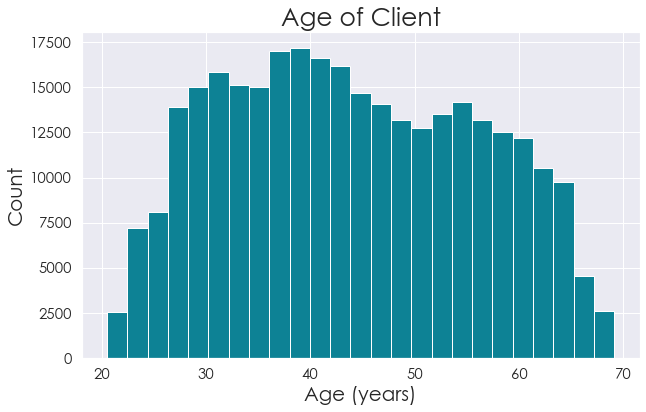

In [49]:
set_style_pers()
# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target. A kernel density estimate plot shows the distribution of a single variable and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn kdeplot for this graph.

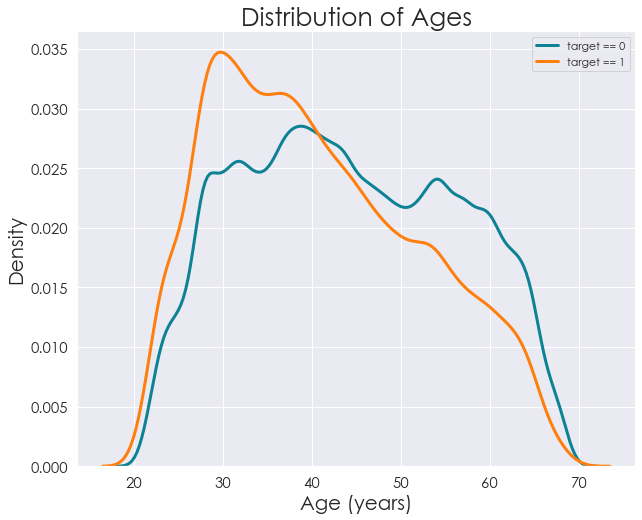

In [50]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')

# plotting legend
plt.legend(loc='best')

In [51]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

<ipython-input-51-487f065f0647>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
<ipython-input-51-487f065f0647>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))


TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

#### Exterior Sources

The 3 variables with the strongest negative correlations with the target are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data.

Let's take a look at these variables.

First, we can show the correlations of the EXT_SOURCE features with the target and with each other.

In [52]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

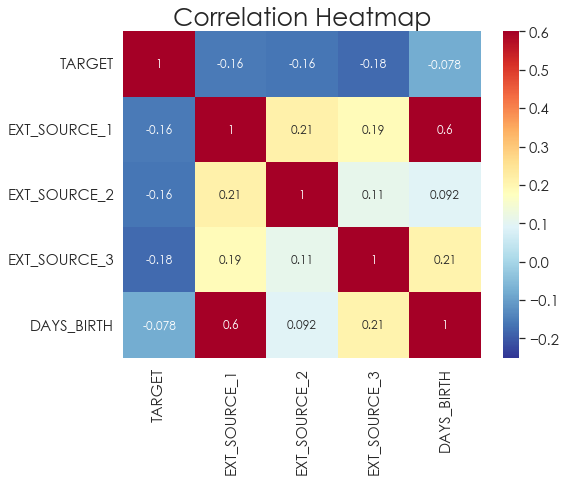

In [53]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three EXT_SOURCE featureshave negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

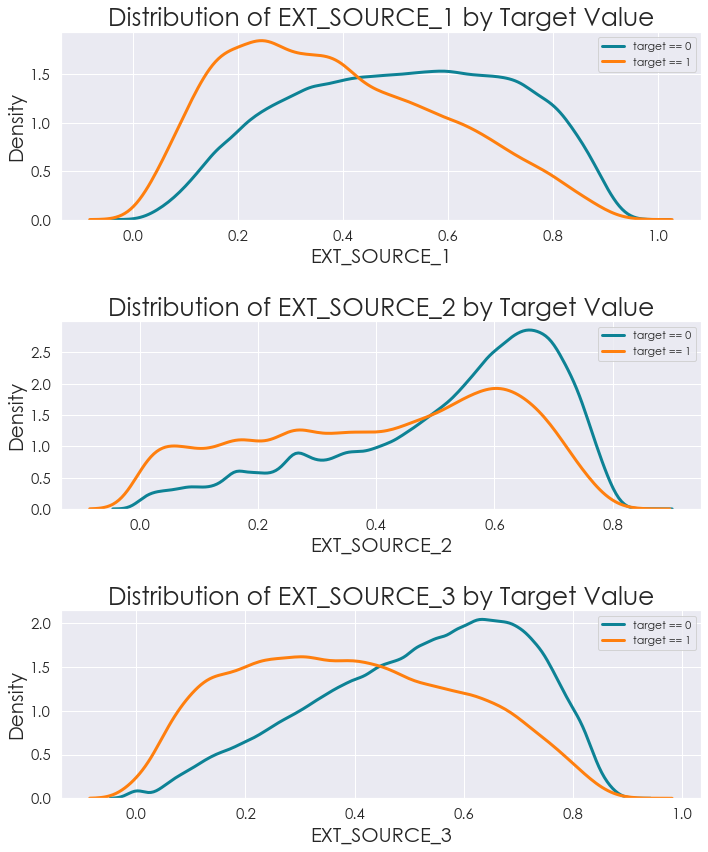

In [54]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density')
    
    plt.legend(loc='best');
    
plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3 displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time

### Pairs Plot

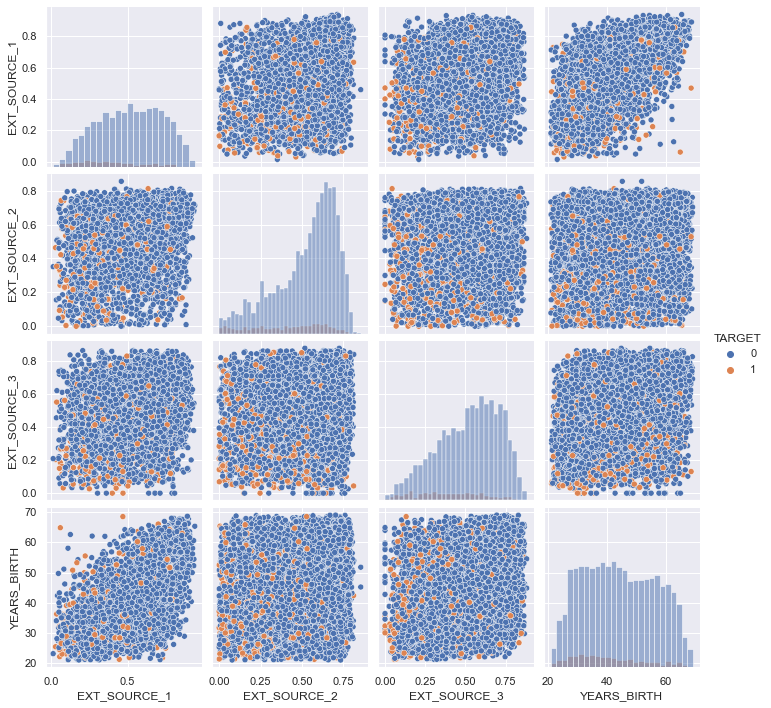

In [55]:
sns.set()
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

sns.pairplot(plot_data.sample(10000, random_state=seed), hue='TARGET', diag_kind='hist')

## Feature Engineering


We will try only two simple feature construction methods:

Polynomial features
Domain knowledge features

### Polynomial features

In [56]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [57]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [58]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:35]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [59]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features.

In [60]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 273)
Testing data with polynomial features shape:   (48744, 273)


In [61]:
# adding the Target to the training data with poly features
app_train_poly['TARGET'] = app_train['TARGET']

In [62]:
# saving training data with and without poly features
list_data = [app_train
             , app_train_poly
             , app_test
             , app_test_poly]

with open("D:/Dowloads_D/Data_OC/P7/app_data.txt", 'wb') as fic:
    mon_pickler = pickle.Pickler(fic)
    mon_pickler.dump(list_data)

### Domain Knowledge Features

Here I'm going to use five features that were inspired by this script by Aguiar:

CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [63]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [64]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

We should explore these domain knowledge variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the TARGET.

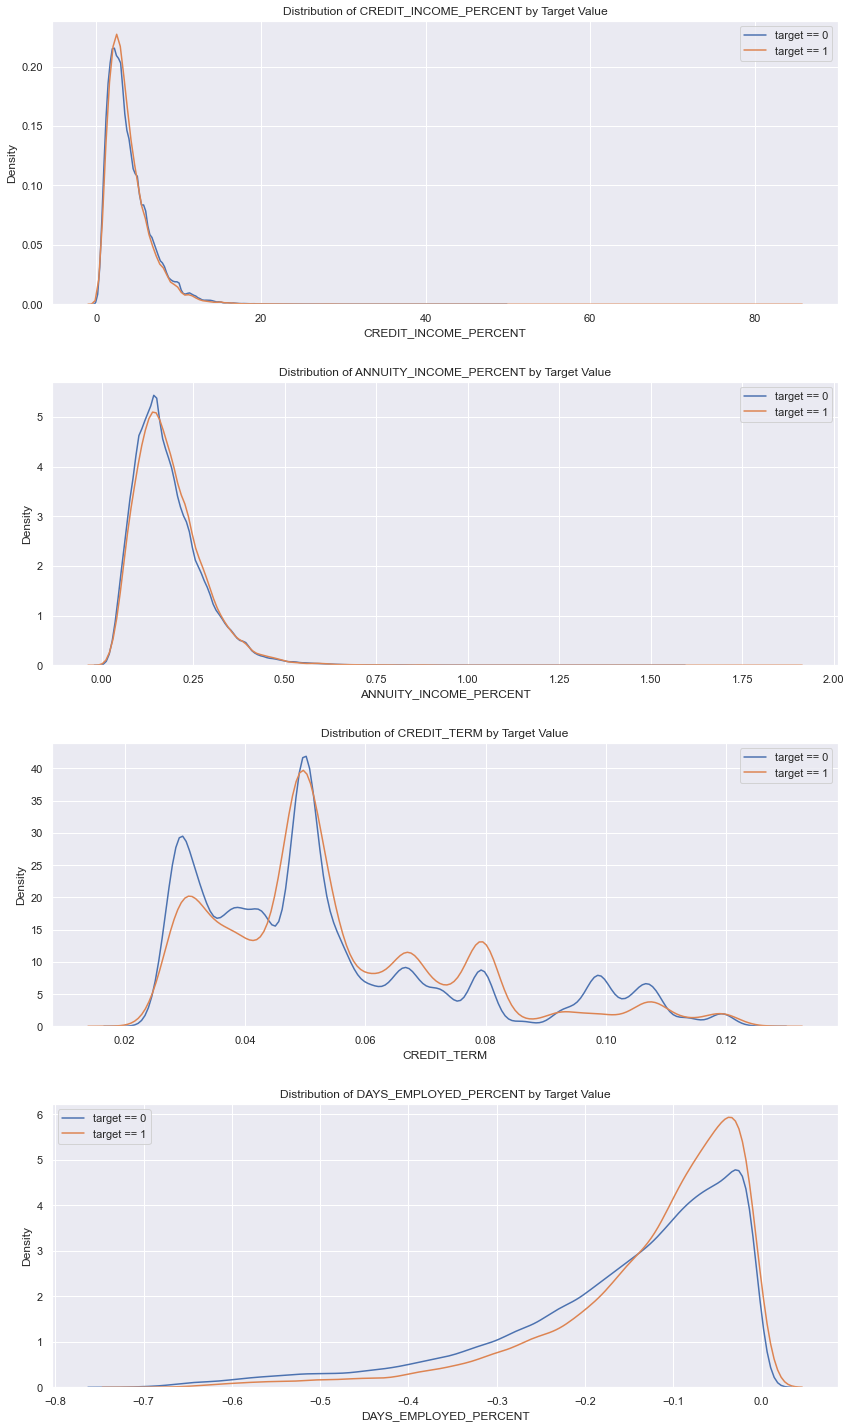

In [65]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density')
    plt.legend(loc='best');
    
plt.tight_layout(h_pad = 2.5)


These graphs do not enable us to assume there is a correlation with the target. We will not include these domain knowledge features 

# Bureau datasets

bureau: information about client's previous loans with other financial institutions reported to Home Credit. Each previous loan has its own row.
    
bureau_balance: monthly information about the previous loans. Each month has its own row.

In [66]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [67]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [68]:
bureau.isna().mean().sort_values(ascending=False)

AMT_ANNUITY               0.714735
AMT_CREDIT_MAX_OVERDUE    0.655133
DAYS_ENDDATE_FACT         0.369170
AMT_CREDIT_SUM_LIMIT      0.344774
AMT_CREDIT_SUM_DEBT       0.150119
DAYS_CREDIT_ENDDATE       0.061496
AMT_CREDIT_SUM            0.000008
CREDIT_ACTIVE             0.000000
CREDIT_CURRENCY           0.000000
DAYS_CREDIT               0.000000
CREDIT_DAY_OVERDUE        0.000000
SK_ID_BUREAU              0.000000
CNT_CREDIT_PROLONG        0.000000
AMT_CREDIT_SUM_OVERDUE    0.000000
CREDIT_TYPE               0.000000
DAYS_CREDIT_UPDATE        0.000000
SK_ID_CURR                0.000000
dtype: float64

In [69]:
bureau_balance.isna().mean().sort_values(ascending=False)

SK_ID_BUREAU      0.0
MONTHS_BALANCE    0.0
STATUS            0.0
dtype: float64

## Features Engineering

### Counts of Bureau Dataframe

In [70]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

bureau_CREDIT_ACTIVE_Active_count  \
SK_ID_CURR                                      
100001                                      3   
100002                                      2   
100003                                      1   
100004                                      0   
100005                                      2   

            bureau_CREDIT_ACTIVE_Active_count_norm  \
SK_ID_CURR                                           
100001                                    0.428571   
100002                                    0.250000   
100003                                    0.250000   
100004                                    0.000000   
100005                                    0.666667   

            bureau_CREDIT_ACTIVE_Bad debt_count  \
SK_ID_CURR                                        
100001                                        0   
100002                                        0   
100003                                        0   
100004                                        0   
100005                                        0   

            bureau_CREDIT_ACTIVE_Bad debt_count_norm  \
SK_ID_CURR                                             
100001                                           0.0   
100002                                           0.0   
100003                                           0.0   
100004                                           0.0   
100005                                           0.0   

            bureau_CREDIT_ACTIVE_Closed_count  \
SK_ID_CURR                                      
100001                                      4   
100002                                      6   
100003                                      3   
100004                                      2   
100005                                      1   

            bureau_CREDIT_ACTIVE_Closed_count_norm  \
SK_ID_CURR                                           
100001                                    0.571429   
100002                                    0.750000   
100003                                    0.750000   
100004                                    1.000000   
100005                                    0.333333   

            bureau_CREDIT_ACTIVE_Sold_count  \
SK_ID_CURR                                    
100001                                    0   
100002                                    0   
100003                                    0   
100004                                    0   
100005                                    0   

            bureau_CREDIT_ACTIVE_Sold_count_norm  \
SK_ID_CURR                                         
100001                                       0.0   
100002                                       0.0   
100003                                       0.0   
100004                                       0.0   
100005                                       0.0   

            bureau_CREDIT_CURRENCY_currency 1_count  \
SK_ID_CURR                                            
100001                                            7   
100002                                            8   
100003                                            4   
100004                                            2   
100005                                            3   

            bureau_CREDIT_CURRENCY_currency 1_count_norm  \
SK_ID_CURR                                                 
100001                                               1.0   
100002                                               1.0   
100003                                               1.0   
100004                                               1.0   
100005                                               1.0   

            bureau_CREDIT_CURRENCY_currency 2_count  \
SK_ID_CURR                                            
100001                                            0   
100002                                            0   
100003                                            0   
100004                                

### Aggregated Stats of Bureau Dataframe

In [71]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

<ipython-input-66-5e12b75d4d00>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df[group_var] = group_ids


SK_ID_CURR  bureau_DAYS_CREDIT_count  bureau_DAYS_CREDIT_mean  \
0      100001                         7              -735.000000   
1      100002                         8              -874.000000   
2      100003                         4             -1400.750000   
3      100004                         2              -867.000000   
4      100005                         3              -190.666667   

   bureau_DAYS_CREDIT_max  bureau_DAYS_CREDIT_min  bureau_DAYS_CREDIT_sum  \
0                     -49                   -1572                   -5145   
1                    -103                   -1437                   -6992   
2                    -606                   -2586                   -5603   
3                    -408                   -1326                   -1734   
4                     -62                    -373                    -572   

   bureau_CREDIT_DAY_OVERDUE_count  bureau_CREDIT_DAY_OVERDUE_mean  \
0                                7                             0.0   
1                                8                             0.0   
2                                4                             0.0   
3                                2                             0.0   
4                                3                             0.0   

   bureau_CREDIT_DAY_OVERDUE_max  bureau_CREDIT_DAY_OVERDUE_min  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   bureau_CREDIT_DAY_OVERDUE_sum  bureau_DAYS_CREDIT_ENDDATE_count  \
0                              0                                 7   
1                              0                                 6   
2                              0                                 4   
3                              0                                 2   
4                              0                                 3   

   bureau_DAYS_CREDIT_ENDDATE_mean  bureau_DAYS_CREDIT_ENDDATE_max  \
0                        82.428571                          1778.0   
1                      -349.000000                           780.0   
2                      -544.500000                          1216.0   
3                      -488.500000                          -382.0   
4                       439.333333                          1324.0   

   bureau_DAYS_CREDIT_ENDDATE_min  bureau_DAYS_CREDIT_ENDDATE_sum  \
0                         -1329.0                           577.0   
1                         -1072.0                         -2094.0   
2                         -2434.0                         -2178.0   
3                          -595.0                          -977.0   
4                          -128.0                          1318.0   

   bureau_DAYS_ENDDATE_FACT_count  bureau_DAYS_ENDDATE_FACT_mean  \
0                               4                    -825.500000   
1                               6                    -697.500000   
2                               3                   -1097.333333   
3                               2                    -532.500000   
4                               1                    -123.000000   

   bureau_DAYS_ENDDATE_FACT_max  bureau_DAYS_ENDDATE_FACT_min  \
0                        -544.0                       -1328.0   
1                         -36.0                       -1185.0   
2                        -540.0                       -2131.0   
3                        -382.0                        -683.0   
4                        -123.0                        -123.0   

   bureau_DAYS_ENDDATE_FACT_sum  bureau_AMT_CREDIT_MAX_OVERDUE_count  \
0                       -3302.0                                    0   
1                       -4185.0                                    5   
2                       -3292.0   

### Value counts of Bureau Balance dataframe by loan

In [72]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

bureau_balance_STATUS_0_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   5   
5001711                                   3   
5001712                                  10   
5001713                                   0   

              bureau_balance_STATUS_0_count_norm  \
SK_ID_BUREAU                                       
5001709                                 0.000000   
5001710                                 0.060241   
5001711                                 0.750000   
5001712                                 0.526316   
5001713                                 0.000000   

              bureau_balance_STATUS_1_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   0   
5001711                                   0   
5001712                                   0   
5001713                                   0   

              bureau_balance_STATUS_1_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   
5001710                                      0.0   
5001711                                      0.0   
5001712                                      0.0   
5001713                                      0.0   

              bureau_balance_STATUS_2_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   0   
5001711                                   0   
5001712                                   0   
5001713                                   0   

              bureau_balance_STATUS_2_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   
5001710                                      0.0   
5001711                                      0.0   
5001712                                      0.0   
5001713                                      0.0   

              bureau_balance_STATUS_3_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   0   
5001711                                   0   
5001712                                   0   
5001713                                   0   

              bureau_balance_STATUS_3_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   
5001710                                      0.0   
5001711                                      0.0   
5001712                                      0.0   
5001713                                      0.0   

              bureau_balance_STATUS_4_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   0   
5001711                                   0   
5001712                                   0   
5001713                                   0   

              bureau_balance_STATUS_4_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   
5001710                                      0.0   
5001711                                      0.0   
5001712                                      0.0   
5001713                                      0.0   

              bureau_balance_STATUS_5_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   0   
5001711                                   0   
5001712                                   0   
5001713                                   0   

              bureau_balance_STATUS_5_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   
5001710                                      0.0   
5

### Aggregated stats of Bureau Balance dataframe by loan

In [73]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

<ipython-input-66-5e12b75d4d00>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df[group_var] = group_ids


SK_ID_BUREAU  bureau_balance_MONTHS_BALANCE_count  \
0       5001709                                   97   
1       5001710                                   83   
2       5001711                                    4   
3       5001712                                   19   
4       5001713                                   22   

   bureau_balance_MONTHS_BALANCE_mean  bureau_balance_MONTHS_BALANCE_max  \
0                               -48.0                                  0   
1                               -41.0                                  0   
2                                -1.5                                  0   
3                                -9.0                                  0   
4                               -10.5                                  0   

   bureau_balance_MONTHS_BALANCE_min  bureau_balance_MONTHS_BALANCE_sum  
0                                -96                              -4656  
1                                -82                              -3403  
2                                 -3                                 -6  
3                                -18                               -171  
4                                -21                               -231

### Aggregated Stats of Bureau Balance by Client

In [74]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

 ## Merge new features to application data

In [75]:
# we will merge new features from the bureau dataset to the application dataset enriched with poly features
os.chdir('D:/Dowloads_D/Data_OC/P7' )
train = app_train_poly

In [76]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  274


In [77]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [78]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  485


Let's do the same operation to application test data

In [79]:
# Read in the test dataframe
test = app_test_poly

# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [80]:
# checking alignment of training and test data

train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

## missing values

In [81]:
# train
train.isna().mean().sort_values(ascending=False)

bureau_AMT_ANNUITY_mean                          0.739817
bureau_AMT_ANNUITY_max                           0.739817
bureau_AMT_ANNUITY_min                           0.739817
client_bureau_balance_MONTHS_BALANCE_mean_max    0.700073
client_bureau_balance_MONTHS_BALANCE_max_max     0.700073
                                                   ...   
ORGANIZATION_TYPE_Realtor                        0.000000
ORGANIZATION_TYPE_Postal                         0.000000
ORGANIZATION_TYPE_Police                         0.000000
ORGANIZATION_TYPE_Other                          0.000000
TARGET                                           0.000000
Length: 485, dtype: float64

In [82]:
# test
test.isna().mean().sort_values(ascending=False)

COMMONAREA_AVG              0.687161
COMMONAREA_MEDI             0.687161
COMMONAREA_MODE             0.687161
NONLIVINGAPARTMENTS_MEDI    0.684125
NONLIVINGAPARTMENTS_MODE    0.684125
                              ...   
ORGANIZATION_TYPE_Postal    0.000000
ORGANIZATION_TYPE_Police    0.000000
ORGANIZATION_TYPE_Other     0.000000
ORGANIZATION_TYPE_Mobile    0.000000
DAYS_BIRTH_y                0.000000
Length: 484, dtype: float64

Both train and test datasets have a maximum NaN rate per feature of 74%, we will keep these colmuns in case they have relevant information for positive cases

## saving featured bureau data

In [83]:
# Saving train and test data containing application datasets enriched with poly features and data agregated form the bureau datasets
list_data = [train
            , test
            ]

with open("D:/Dowloads_D/Data_OC/P7/bureau_data.txt", 'wb') as fic:
    mon_pickler = pickle.Pickler(fic)
    mon_pickler.dump(list_data)

## loading checkpoint

In [84]:
with open("D:/Dowloads_D/Data_OC/P7/bureau_data.txt", 'rb') as fic:
    mon_depickler = pickle.Unpickler(fic)
    loaded = mon_depickler.load()

train, test = loaded

## Correlations

First let's look at the correlations of the variables with the target. We can see some of the variables we created have a greater correlation than those already present in the training data (from application).

In [85]:
# Calculate all correlations in dataframe
corrs = train.corr()

In [86]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

TARGET
TARGET                                          1.000000
bureau_DAYS_CREDIT_mean                         0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean   0.089038
bureau_CREDIT_ACTIVE_Active_count_norm          0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean  0.076424
bureau_DAYS_CREDIT_min                          0.075248
DAYS_EMPLOYED                                   0.074958
client_bureau_balance_MONTHS_BALANCE_min_min    0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean   0.072606
bureau_DAYS_CREDIT_UPDATE_mean                  0.068927

In [87]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

TARGET
EXT_SOURCE_2_y                         -0.160295
EXT_SOURCE_2_x                         -0.160472
EXT_SOURCE_1 EXT_SOURCE_3              -0.164065
EXT_SOURCE_1 EXT_SOURCE_2              -0.166625
EXT_SOURCE_2 EXT_SOURCE_3^2            -0.172282
EXT_SOURCE_2^2 EXT_SOURCE_3            -0.176428
EXT_SOURCE_3_x                         -0.178919
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH   -0.181283
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3 -0.189605
EXT_SOURCE_2 EXT_SOURCE_3              -0.193939

The highest correlated variable with the target (other than the TARGET which of course has a correlation of 1), is a variable we created. However, just because the variable is correlated does not mean that it will be useful, and we have to remember that if we generate hundreds of new variables, some are going to be correlated with the target simply because of random noise.

Viewing the correlations skeptically, it does appear that several of the newly created variables may be useful. To assess the "usefulness" of variables, we will look at the feature importances returned by the model. For curiousity's sake (and because we already wrote the function) we can make a kde plot of two of the newly created variables.

### checking NaN of poly EXT features

In [88]:
train[[col for col in train.columns if 'EXT' in col]].isna().mean().sort_values(ascending=False)

EXT_SOURCE_1_x                            0.563811
EXT_SOURCE_3_x                            0.198253
EXT_SOURCE_2_x                            0.002146
EXT_SOURCE_3^2 DAYS_BIRTH                 0.000000
EXT_SOURCE_3^3                            0.000000
EXT_SOURCE_2 DAYS_BIRTH^2                 0.000000
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH      0.000000
EXT_SOURCE_2 EXT_SOURCE_3^2               0.000000
EXT_SOURCE_2^2 DAYS_BIRTH                 0.000000
EXT_SOURCE_1^2 DAYS_BIRTH                 0.000000
EXT_SOURCE_2^3                            0.000000
EXT_SOURCE_1 DAYS_BIRTH^2                 0.000000
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH      0.000000
EXT_SOURCE_1 EXT_SOURCE_3^2               0.000000
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH      0.000000
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3    0.000000
EXT_SOURCE_1 EXT_SOURCE_2^2               0.000000
EXT_SOURCE_2^2 EXT_SOURCE_3               0.000000
EXT_SOURCE_1^2 EXT_SOURCE_3               0.000000
EXT_SOURCE_1^2 EXT_SOURCE_2    

we delete EXT_SOURCE_1_x and EXT_SOURCE_3_x beacuse of their high Nan rate (56% and 19%). Given their correlation to the target, imputing them will represent a risk of biasing the dataset

In [89]:
train.drop(['EXT_SOURCE_1_x', 'EXT_SOURCE_3_x'], axis=1, inplace=True)

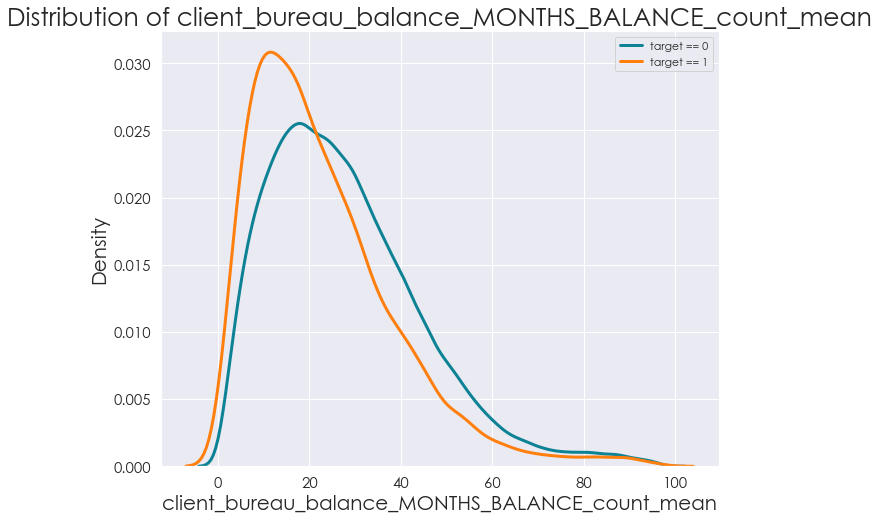

In [90]:
set_style_pers()
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'client_bureau_balance_MONTHS_BALANCE_count_mean'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'client_bureau_balance_MONTHS_BALANCE_count_mean'], label = 'target == 1')

# Labeling of plot
plt.xlabel('client_bureau_balance_MONTHS_BALANCE_count_mean'); plt.ylabel('Density'); plt.title('Distribution of client_bureau_balance_MONTHS_BALANCE_count_mean')

# plotting legend
plt.legend(loc='best')

Based on the distribution, clients with a greater number of average monthly records per loan were more likely to repay their loans with Home Credit. Let's not read too much into this value, but it could indicate that clients who have had more previous credit history are generally more likely to repay a loan

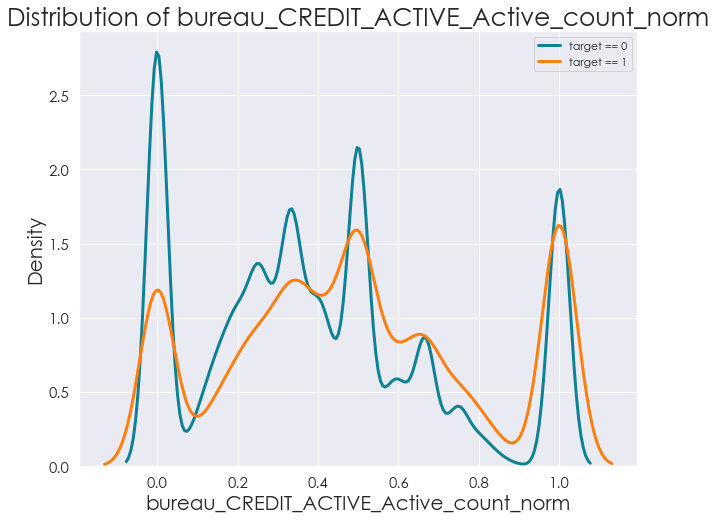

In [91]:
set_style_pers()

plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'bureau_CREDIT_ACTIVE_Active_count_norm'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'bureau_CREDIT_ACTIVE_Active_count_norm'], label = 'target == 1')

# Labeling of plot
plt.xlabel('bureau_CREDIT_ACTIVE_Active_count_norm'); plt.ylabel('Density'); plt.title('Distribution of bureau_CREDIT_ACTIVE_Active_count_norm')

# plotting legend
plt.legend(loc='best')

Well this distribution is all over the place. This variable represents the number of previous loans with a CREDIT_ACTIVE value of Active divided by the total number of previous loans for a client. The correlation here is so weak that I do not think we should draw any conclusions!

### colinear variables

We can calculate not only the correlations of the variables with the target, but also the correlation of each variable with every other variable. This will allow us to see if there are highly collinear variables that should perhaps be removed from the data.

Let's look for any variables that have a greather than 0.8 correlation with other variables.

In [92]:
# here is a list of columns to keep even if colinear as they are easily interpretable
cols_to_keep =[
    'DAYS_EMPLOYED'
    , 'DAYS_EMPLOYED_ANOM'
    , 'NAME_EDUCATION_TYPE'
    , 'OCCUPATION_TYPE'
    , 'DAYS_BIRTH'
]

In [93]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

For each of these pairs of highly correlated variables, we only want to remove one of the variables. The following code creates a set of variables to remove by only adding one of each pair.

In [94]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)

In [95]:
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  170


We can remove these columns from both the training and the testing datasets.

In [96]:
# let's exclude any column we want to keep before removing colinear features:
cols_to_remove = [col for col in cols_to_remove if col not in cols_to_keep]

In [97]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 314)
Testing Corrs Removed Shape:  (48744, 315)


In [98]:
[col for col in train_corrs_removed.columns if col not in test_corrs_removed.columns]

['TARGET']

In [99]:
[col for col in test_corrs_removed.columns if col not in train_corrs_removed.columns]

['EXT_SOURCE_1_x', 'EXT_SOURCE_3_x']

These two columns are in the testing dataset but not in the training one, removing them

In [100]:
test_corrs_removed = test_corrs_removed.drop(columns = ['EXT_SOURCE_1_x', 'EXT_SOURCE_3_x'])

### saving uncorrelated datasets

In [101]:
# On sauvegarde les datasets sans et avec les features poly
list_data = [train_corrs_removed
            , test_corrs_removed
            ]

with open("D:/Dowloads_D/Data_OC/P7/uncorr_data.txt", 'wb') as fic:
    mon_pickler = pickle.Pickler(fic)
    mon_pickler.dump(list_data)

In [102]:
# using pd.to_pickle in case of later incompatibility with pickle
train_corrs_removed.to_pickle("D:/Dowloads_D/Data_OC/P7/train_corrs_removed.pkl")
test_corrs_removed.to_pickle("D:/Dowloads_D/Data_OC/P7/test_corrs_removed.pkl")